In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_train_nan = pd.read_csv('weatherHistory_training_nan.csv')
df_train_nan = df_train_nan['Temperature (C)']
df_train_nan.shape

(70000,)

In [3]:
df_train_nan_mask = df_train_nan.isna()
df_train_nan_mask.shape

(70000,)

In [18]:
def split_data(df, input_size):
    segments = []
    for idx in range(0, 70000-input_size, 100):
        begin = idx
        end = begin + input_size        
        segment = df[begin:end].to_numpy()
        segments.append(segment)

    # Chuyển list thành np.ndarrray
    segments = np.array(segments)
    return segments

In [19]:
input_size = 500
df_train_nan = df_train_nan.fillna(1000)
segments_train_nan = split_data(df_train_nan, input_size)
print(segments_train_nan.shape)
print(segments_train_nan[0,:20])

(695, 500)
[5.77777778e-01 1.16111111e+00 1.66666667e+00 1.71111111e+00
 1.18333333e+00 1.20555556e+00 2.22222222e+00 2.07222222e+00
 2.20000000e+00 1.00000000e+03 2.78888889e+00 1.00000000e+03
 4.91111111e+00 6.20555556e+00 1.00000000e+03 6.95000000e+00
 5.97222222e+00 5.90555556e+00 4.95555556e+00 5.47222222e+00]


In [20]:
segments_train_nan_mask = split_data(df_train_nan_mask, input_size)
print(segments_train_nan_mask.shape)
print(segments_train_nan_mask[0,:20])

(695, 500)
[False False False False False False False False False  True False  True
 False False  True False False False False False]


In [7]:
segments_train_nan = segments_train_nan.reshape((segments_train_nan.shape[0], segments_train_nan.shape[1], 1))
print(segments_train_nan.shape)

segments_train_nan_mask = segments_train_nan_mask.reshape((segments_train_nan_mask.shape[0], segments_train_nan_mask.shape[1], 1))
print(segments_train_nan_mask.shape)

(69500, 500, 1)
(69500, 500, 1)


In [8]:
x_train_input = np.concatenate([segments_train_nan, segments_train_nan_mask], axis=2)
print(x_train_input.shape)

(69500, 500, 2)


In [9]:
print(x_train_input[0, :20, 0])

[5.77777778e-01 1.16111111e+00 1.66666667e+00 1.71111111e+00
 1.18333333e+00 1.20555556e+00 2.22222222e+00 2.07222222e+00
 2.20000000e+00 1.00000000e+03 2.78888889e+00 1.00000000e+03
 4.91111111e+00 6.20555556e+00 1.00000000e+03 6.95000000e+00
 5.97222222e+00 5.90555556e+00 4.95555556e+00 5.47222222e+00]


In [10]:
print(x_train_input[0, :20, 1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]


In [11]:
df_train = pd.read_csv('https://www.dropbox.com/s/5cgteeozyccaf6n/weatherHistory_training.csv?dl=1')
df_train = df_train['Temperature (C)']
print(df_train.shape)
df_train.head(5)

(70000,)


0    0.577778
1    1.161111
2    1.666667
3    1.711111
4    1.183333
Name: Temperature (C), dtype: float64

In [12]:
x_train_target = split_data(df_train, input_size)
print(x_train_target.shape)
print(x_train_target[0,:20])

(69500, 500)
[0.57777778 1.16111111 1.66666667 1.71111111 1.18333333 1.20555556
 2.22222222 2.07222222 2.2        2.73333333 2.78888889 3.82222222
 4.91111111 6.20555556 7.43888889 6.95       5.97222222 5.90555556
 4.95555556 5.47222222]


In [13]:
x_train_target = x_train_target.reshape((x_train_target.shape[0], x_train_target.shape[1], 1))
print(x_train_target.shape)

(69500, 500, 1)


In [14]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train_input, x_train_target)).batch(32)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
for x_nan, x_target in train_ds:
    print(x_nan.shape)
    print(x_target.shape)
    break

(32, 500, 2)
(32, 500, 1)


## Build a model

In [16]:
input_layer = keras.layers.Input((500, 2))

origin = input_layer[:,:,0]
condition = tf.cast(input_layer[:,:,1], dtype=tf.bool)

x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)

x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.PReLU()(x)

x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.PReLU()(x)

x = keras.layers.Conv1D(filters=1, kernel_size=3, padding="same")(x)
x = keras.layers.Flatten()(x)

x = tf.where(condition, x, origin)

model_fill = keras.models.Model(inputs=input_layer, outputs=x)
model_fill.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 2)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 500, 64)      448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 500, 64)     256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 500, 64)      0           ['batch_normalization[0][0]']

## Train the model

In [17]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=20, min_lr=0.0001),
]
model_fill.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mse"],
)
history = model_fill.fit(train_ds,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/500
 138/2172 [>.............................] - ETA: 4:02 - loss: 3.7291 - mse: 3.7291

KeyboardInterrupt: 

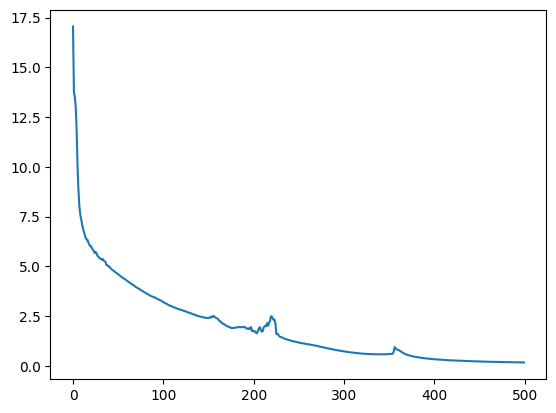

In [65]:
metric = "mse"
plt.plot(history.history[metric])
plt.show()

## Reconstruct training data

In [66]:
df_train_nan_full = pd.read_csv('weatherHistory_training_nan.csv')
df_train_nan = df_train_nan_full['Temperature (C)']
df_train_nan.shape

(70000,)

In [67]:
df_train_nan_mask = df_train_nan.isna()
df_train_nan_mask.shape

(70000,)

In [68]:
def split_data_reconstruction(df, input_size):
    segments = []
    for idx in range(0, 70000, input_size):
        begin = idx
        end = begin + input_size        
        segment = df[begin:end].to_numpy()
        segments.append(segment)

    # Chuyển list thành np.ndarrray
    segments = np.array(segments)
    return segments

In [69]:
input_size = 500
df_train_nan = df_train_nan.fillna(1000)
segments_train_nan = split_data_reconstruction(df_train_nan, input_size)
print(segments_train_nan.shape)
print(segments_train_nan[0,:15])

(140, 500)
[5.77777778e-01 1.16111111e+00 1.66666667e+00 1.71111111e+00
 1.18333333e+00 1.20555556e+00 2.22222222e+00 2.07222222e+00
 2.20000000e+00 1.00000000e+03 2.78888889e+00 1.00000000e+03
 4.91111111e+00 6.20555556e+00 1.00000000e+03]


In [70]:
segments_train_nan_mask = split_data_reconstruction(df_train_nan_mask, input_size)
print(segments_train_nan_mask.shape)
print(segments_train_nan_mask[0,:15])

(140, 500)
[False False False False False False False False False  True False  True
 False False  True]


In [71]:
segments_train_nan = segments_train_nan.reshape((segments_train_nan.shape[0], segments_train_nan.shape[1], 1))
print(segments_train_nan.shape)

segments_train_nan_mask = segments_train_nan_mask.reshape((segments_train_nan_mask.shape[0], segments_train_nan_mask.shape[1], 1))
print(segments_train_nan_mask.shape)

x_train_input = np.concatenate([segments_train_nan, segments_train_nan_mask], axis=2)
print(x_train_input.shape)

(140, 500, 1)
(140, 500, 1)
(140, 500, 2)


In [73]:
x_train_filled = model_fill(x_train_input, training=False).numpy()
print(x_train_filled.shape)

(140, 500)


In [75]:
df_train_nan[:15].to_numpy()

array([5.77777778e-01, 1.16111111e+00, 1.66666667e+00, 1.71111111e+00,
       1.18333333e+00, 1.20555556e+00, 2.22222222e+00, 2.07222222e+00,
       2.20000000e+00, 1.00000000e+03, 2.78888889e+00, 1.00000000e+03,
       4.91111111e+00, 6.20555556e+00, 1.00000000e+03])

In [77]:
x_train_filled[0, :15]

array([0.5777778, 1.1611111, 1.6666666, 1.7111111, 1.1833333, 1.2055556,
       2.2222223, 2.0722222, 2.2      , 2.044559 , 2.788889 , 3.926437 ,
       4.911111 , 6.2055554, 5.950381 ], dtype=float32)

In [78]:
x_train_filled = x_train_filled.reshape(-1,)
print(x_train_filled.shape)

(70000,)


In [79]:
df_train_nan_full['Temperature (C)'] = x_train_filled

In [80]:
df_train_nan_full['Temperature (C)'][:15].to_numpy()

array([0.5777778, 1.1611111, 1.6666666, 1.7111111, 1.1833333, 1.2055556,
       2.2222223, 2.0722222, 2.2      , 2.044559 , 2.788889 , 3.926437 ,
       4.911111 , 6.2055554, 5.950381 ], dtype=float32)

In [81]:
df_train_nan_full.to_csv("train_filled.csv", index=False)